# 신경망 모델 훈련

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/7-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 손실 곡선

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


2022-01-08 04:42:57.842599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # verbose = 0 : 훈련 과정을 나타내지 않음

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


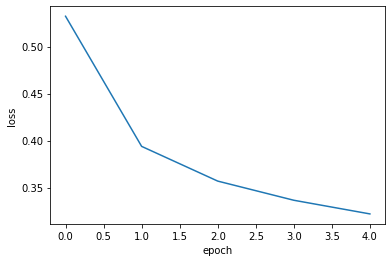

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

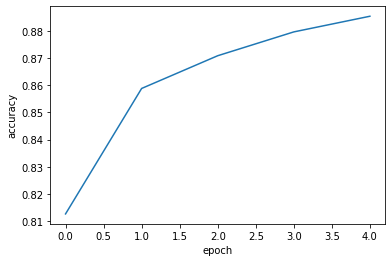

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

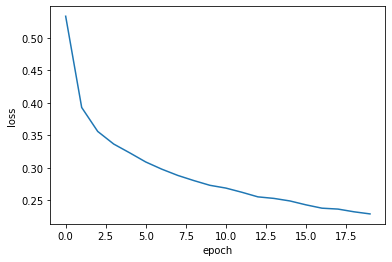

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


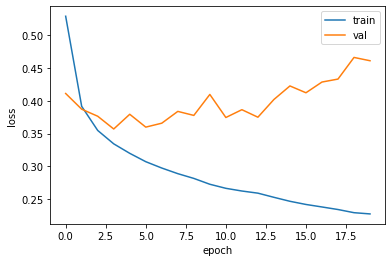

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 전형적인 과대적합 모양. 

In [ ]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

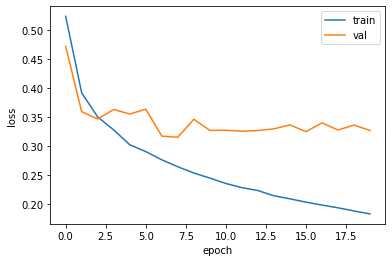

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 과대적합 해결책 : 드롭아웃

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

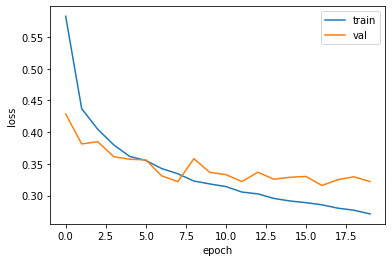

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [ ]:
model.save_weights('model-weights.h5') # 모델 저장

In [ ]:
model.save('model-whole.h5')

In [ ]:
!ls -al *.h5

-rw-r--r-- 1 haesun haesun 4049416 Jan  8 04:48 best-cnn-model.h5
-rw-r--r-- 1 haesun haesun  333448 Jan  8 04:48 model-weights.h5
-rw-r--r-- 1 haesun haesun  982664 Jan  8 04:48 model-whole.h5


In [ ]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

In [ ]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8804166666666666


In [ ]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3281 - accuracy: 0.8804


[0.32808488607406616, 0.8804166913032532]

## 콜백
- 모델 훈련 도중 특정작업을 수행할 수 있도록 함
- 조기종료에 사용됨 

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [ ]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3149 - accuracy: 0.8888


[0.31489625573158264, 0.8888333439826965]

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

- 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련중지 가능
- 최상의 모델을 자동 저장 (.ModelCheckpoint)

In [ ]:
print(early_stopping_cb.stopped_epoch)

8


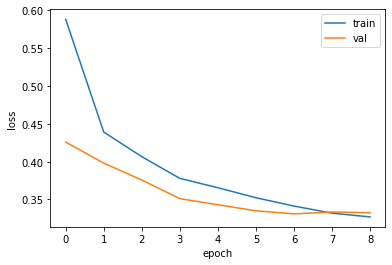

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3310 - accuracy: 0.8803


[0.3309899568557739, 0.8803333044052124]